In [111]:
import numpy as np
import pandas as pd

In [112]:
columns = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education.num",
    "marital.status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital.gain",
    "capital.loss",
    "hours.per.week",
    "native.country",
    "income"
]


In [113]:
df = pd.read_csv("adult.csv")
df.columns = columns

In [114]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [115]:
df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

In [116]:
var_no = ["native.country", "income", "education.num", "fnlwgt"]

binarias = [col for col in df.columns if df[col].nunique() == 2 and col != "income"]
numericas = [col for col in df.columns if df[col].dtype == "int64" and col not in var_no]
categoricas = [col for col in df.columns if col not in (numericas+binarias) and col not in var_no]

In [117]:
binarias

['sex']

In [118]:
categoricas

['workclass',
 'education',
 'marital.status',
 'occupation',
 'relationship',
 'race']

In [119]:
numericas

['age', 'capital.gain', 'capital.loss', 'hours.per.week']

## Cardinalidad

In [120]:
for col in categoricas:
    print(df[col].nunique())

9
16
7
15
6
5


In [121]:
X = df[binarias+categoricas+numericas]
y = df["income"]

In [122]:
map_bin = {
    ' >50K': 1, 
    ' <=50K': 0, 
}

y = y.replace(map_bin)

C:\Users\CRISTIAN\AppData\Local\Temp\ipykernel_19816\1702730473.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace(map_bin)


In [123]:
X.head()

,sex,workclass,education,marital.status,occupation,relationship,race,age,capital.gain,capital.loss,hours.per.week
0,Male,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,50,0,0,13
1,Male,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,38,0,0,40
2,Male,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,53,0,0,40
3,Female,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,28,0,0,40
4,Female,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,37,0,0,40


In [124]:
y.unique()

array([0, 1])

## Train y test

In [125]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [126]:
X_train.shape

(26048, 11)

In [127]:
X_test.shape

(6512, 11)

## Preprocesamiento

In [128]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# RANDOM FOREST ----------------------------------------------------------------

preprocessor_random_forest = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numericas), 
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categoricas + binarias)
    ]
)

# XGBOOST ----------------------------------------------------------------

preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numericas),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categoricas + binarias)
    ]
)

# CATBOOST ----------------------------------------------------------------

preprocessor_catboost = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numericas),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categoricas + binarias) 
    ]
)

## Entrenamientos y pipelines

In [129]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# RANDOM FOREST

pipeline_random_forest = Pipeline(steps=[
    ("preprocessing", preprocessor_random_forest), 
    ("classifier", RandomForestClassifier(random_state=42))
])

param_grid_random_forest = {  
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [10, 20],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 2],
    "classifier__max_features": ["sqrt"],
    "classifier__class_weight": ["balanced"]
}

grid_random_forest = GridSearchCV(
    pipeline_random_forest,
    param_grid=param_grid_random_forest,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

# XGBOOST

pipeline_xgb = Pipeline(steps=[
    ("preprocessing", preprocessor_xgb), 
    ("classifier", XGBClassifier(eval_metric="auc", random_state=42, use_label_encoder=False))
])

param_grid_xgb = {  
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [3, 5],
    "classifier__subsample": [1.0],
    "classifier__reg_alpha": [0, 0.1],
    "classifier__scale_pos_weight": [scale_pos_weight]
}

grid_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

# CATBOOST

pipeline_catboost = Pipeline(steps=[
    ("preprocessing", preprocessor_catboost),  
    ("classifier", CatBoostClassifier(verbose=0, random_state=42, eval_metric="AUC"))
])

param_grid_catboost = {  
    "classifier__iterations": [200],
    "classifier__depth": [4, 6],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__l2_leaf_reg": [1, 3],
    "classifier__scale_pos_weight": [scale_pos_weight]
}

grid_catboost = GridSearchCV(
    pipeline_catboost,
    param_grid=param_grid_catboost,
    cv=5,
    scoring="roc_auc",
    n_jobs=3,
    verbose=1
)

In [131]:
from sklearn.model_selection import cross_val_score

models = {
    "Random Forest": grid_random_forest,
    "XGBoost": grid_xgb,
    "Catboost": grid_catboost,
}

results = []

for name, model in models.items():
    print(f"Entrenando modelo: {name}...")
    
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=3)
    
    results.append({
        "Modelo": name,
        "AUC Medio": scores.mean(),
        "AUC Std": scores.std(),
    })

results_df = pd.DataFrame(results).sort_values(by="AUC Medio", ascending=False).reset_index(drop=True)


print("Comparación de Modelos (AUC en Validación Cruzada):")
display(results_df)

Entrenando modelo: Random Forest...
Entrenando modelo: XGBoost...
Entrenando modelo: Catboost...
Comparación de Modelos (AUC en Validación Cruzada):


,Modelo,AUC Medio,AUC Std
0,XGBoost,0.928117,0.002171
1,Catboost,0.926984,0.001798
2,Random Forest,0.916275,0.001786


In [133]:
X_train.dtypes

sex               object
workclass         object
education         object
marital.status    object
occupation        object
relationship      object
race              object
age                int64
capital.gain       int64
capital.loss       int64
hours.per.week     int64
dtype: object

## Entrenamiento final

In [134]:
grid_random_forest.fit(X_train, y_train)
grid_xgb.fit(X_train, y_train)
grid_catboost.fit(X_train, y_train)

c:\Users\CRISTIAN\miniconda3\envs\DataViz_venv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:23:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['age',
                                                                          'capital.gain',
                                                                          'capital.loss',
                                                                          'hours.per.week']),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital.status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex'])])),
                                       ('classifier',
                                        <catboost.core.CatBoostClassifier object at 0x0000012F370C8160>)]),
             n_jobs=3,
             param_grid={'classifier__depth': [4, 6],
                         'classifier__iterations': [200],
                         'classifier__l2_leaf_reg': [1, 3],
                         'classifier__learning_rate': [0.05, 0.1],
                         'classifier__scale_pos_weight': [3.17369011376382]},
             scoring='roc_auc', verbose=1)

## Hiperparámetros

In [135]:
grids = {
    "Random Forest": grid_random_forest,
    "XGBoost": grid_xgb,
    "Catboost": grid_catboost,
}

print("Mejores hiperparámetros encontrados:\n")
for name, grid in grids.items():
    print(f"{name}:")
    print(grid.best_params_)
    print(f"Mejor AUC en CV: {grid.best_score_:.6f}\n")

Mejores hiperparámetros encontrados:

Random Forest:
{'classifier__class_weight': 'balanced', 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Mejor AUC en CV: 0.916314

XGBoost:
{'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__reg_alpha': 0.1, 'classifier__scale_pos_weight': 3.17369011376382, 'classifier__subsample': 1.0}
Mejor AUC en CV: 0.928338

Catboost:
{'classifier__depth': 6, 'classifier__iterations': 200, 'classifier__l2_leaf_reg': 3, 'classifier__learning_rate': 0.1, 'classifier__scale_pos_weight': 3.17369011376382}
Mejor AUC en CV: 0.927087



## Métricas evaluación


--- Evaluación Random Forest ---
Accuracy:        0.820792
Precision:       0.595924
Recall:          0.840625
F1-score:        0.697433


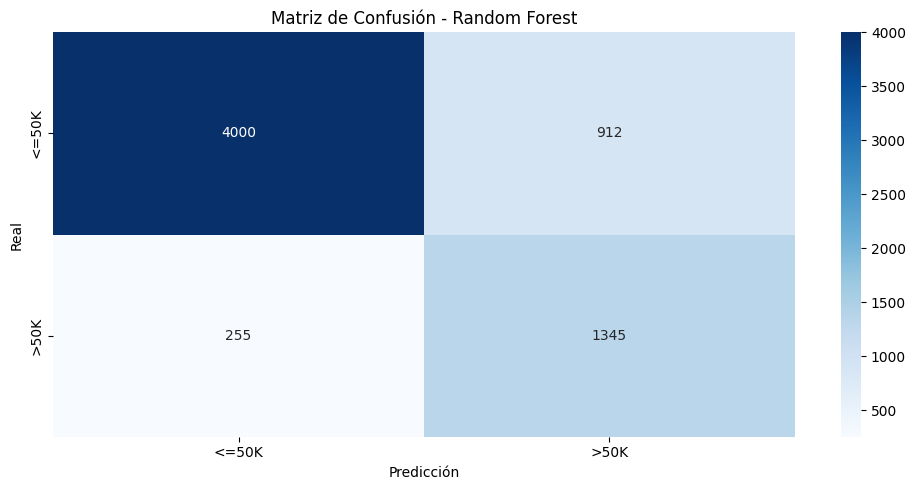

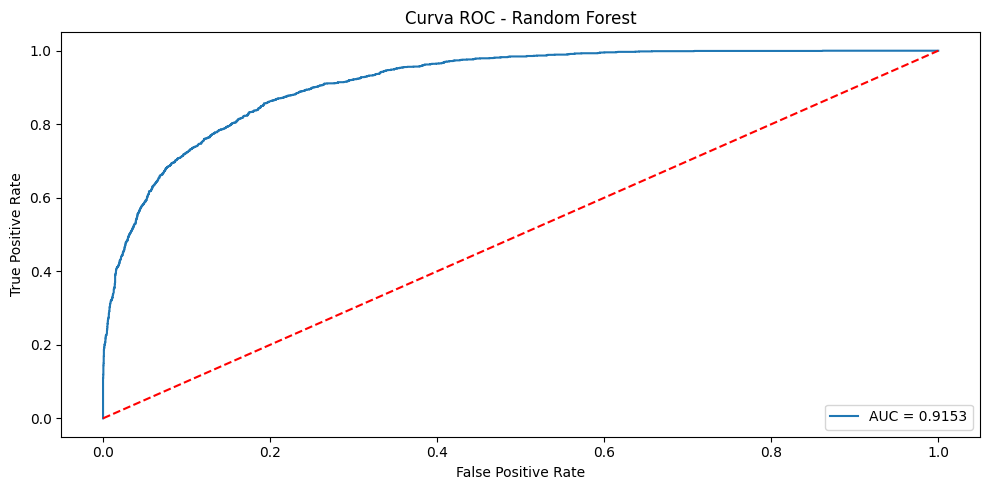


--- Evaluación XGBoost ---
Accuracy:        0.830928
Precision:       0.609574
Recall:          0.867500
F1-score:        0.716018


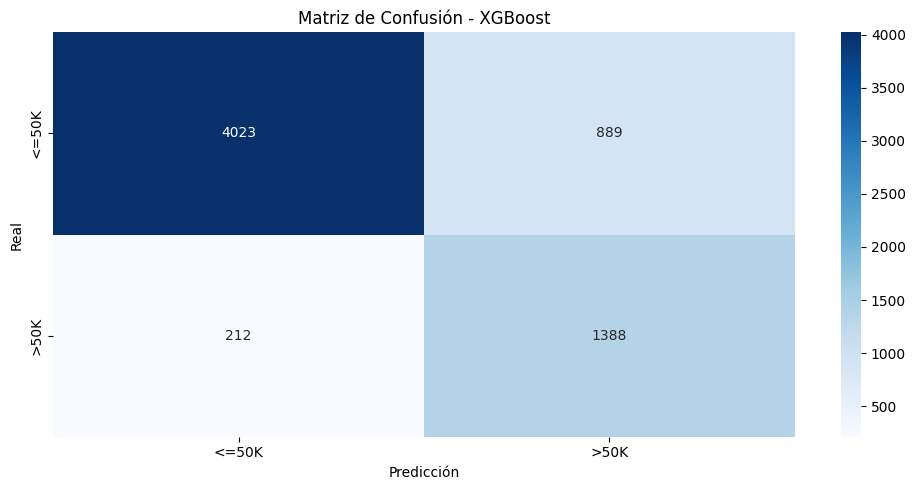

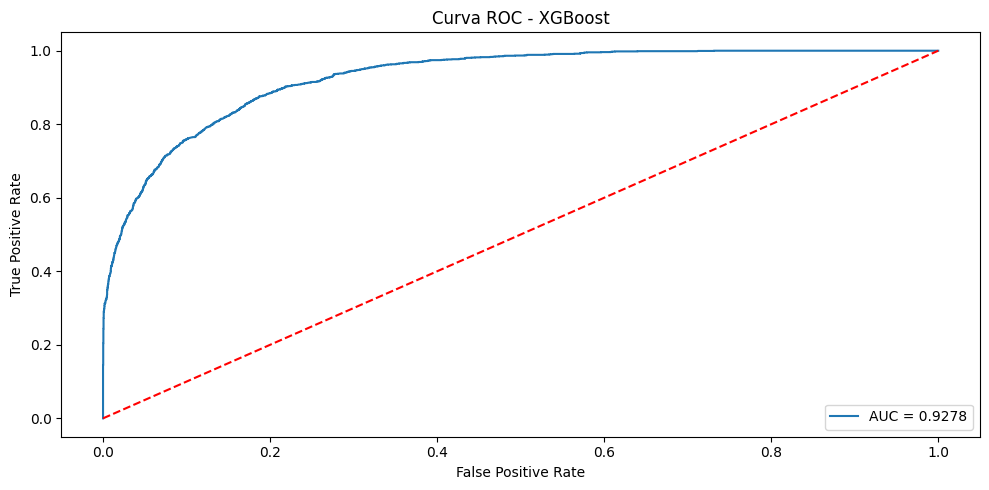


--- Evaluación Catboost ---
Accuracy:        0.826014
Precision:       0.601832
Recall:          0.862500
F1-score:        0.708965


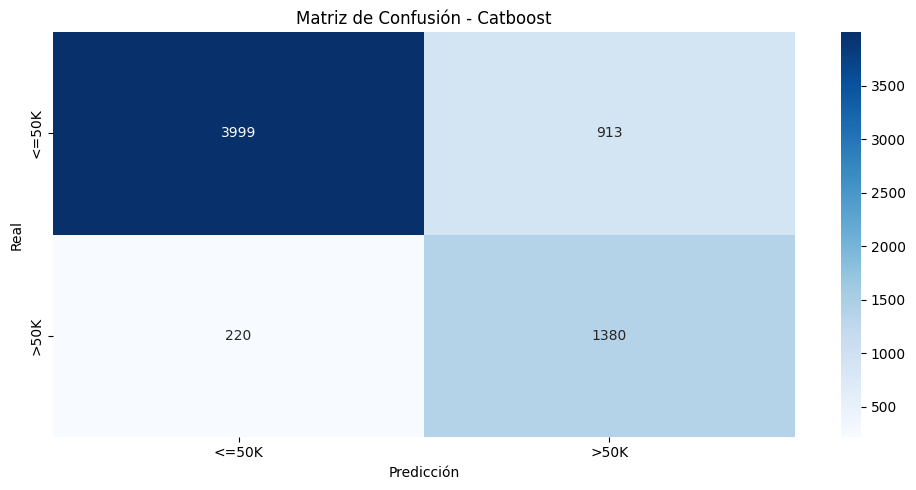

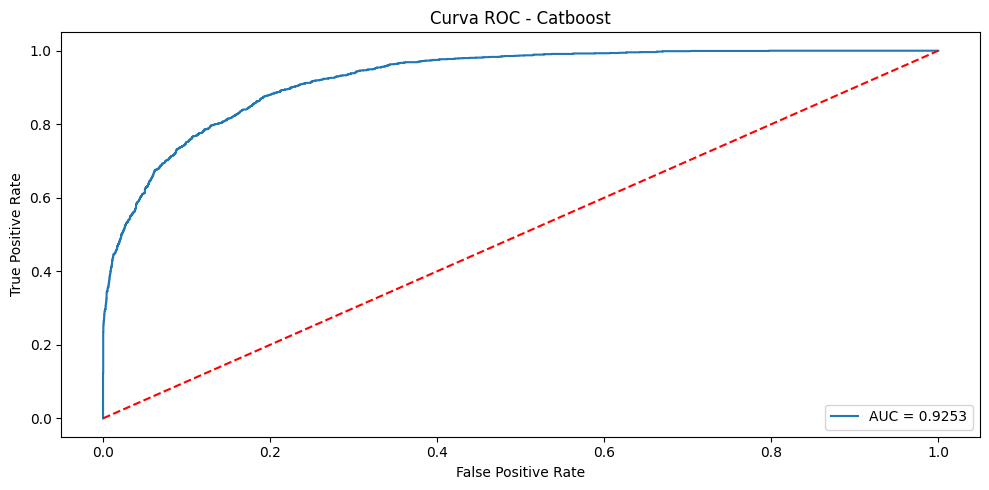

In [139]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

final_models = {
    "Random Forest": grid_random_forest.best_estimator_,
    "XGBoost": grid_xgb.best_estimator_,
    "Catboost": grid_catboost.best_estimator_,
}

for name, model in final_models.items():
    print(f"\n--- Evaluación {name} ---")
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy:        {acc:.6f}")
    print(f"Precision:       {prec:.6f}")
    print(f"Recall:          {rec:.6f}")
    print(f"F1-score:        {f1:.6f}")
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["<=50K", ">50K"],
                yticklabels=["<=50K", ">50K"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión - {name}")
    plt.tight_layout()
    plt.show()
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Curva ROC - {name}")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

## Guardado

In [142]:
import joblib
import os

ruta_modelos = os.path.join("..", "models.joblib")

joblib.dump(final_models, ruta_modelos)

['..\\models.joblib']